<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W2D1-postcourse-bugfix/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA 2020 W2D1 -- (Bonus) Tutorial 4: Bayesian Decision Theory & Cost functions
__Content creators:__ Vincent Valton, Konrad Kording, with help from Matthew Krause

__Content reviewers:__ Matthew Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi

# Tutorial Objectives

*This tutorial is optional! Please do not feel pressured to finish it!*

In the previous tutorials, we investigated the posterior, which describes  beliefs based on a combination of current evidence and prior experience. This tutorial focuses on Bayesian Decision Theory, which combines the posterior with **cost functions** that allow us to quantify the potential impact of making a decision or choosing an action based on that posterior. Cost functions are therefore critical for turning probabilities into actions!

In Tutorial 3, we used the mean of the posterior $p(x | \tilde x)$ as a proxy for the response $\hat x$ for the participants. What prompted us to use the mean of the posterior as a **decision rule**? In this tutorial we will see how different common decision rules such as the choosing the mean, median or mode of the posterior distribution correspond to minimizing different cost functions.

In this tutorial, you will
  1. Implement three commonly-used cost functions: mean-squared error, absolute error, and zero-one loss
  2. Discover the concept of expected loss, and
  3. Choose optimal locations on the posterior that minimize these cost functions. You will verify that it these locations can be found analytically as well as empirically.

Video available at https://youtube.com/watch?v=z2DF4H_sa-k


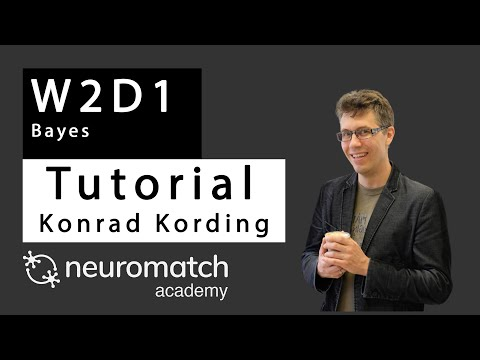

In [1]:
#@title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='z2DF4H_sa-k', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
Please execute the cell below to initialize the notebook environment


--- 
### Setup

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
  """Returns un-normalized Gaussian estimated at points `x_points`

  DO NOT EDIT THIS FUNCTION !!!

  Args :
    x_points (numpy array of floats) - points at which the gaussian is evaluated
    mu (scalar) - mean of the Gaussian
    sigma (scalar) - std of the gaussian

  Returns:
    (numpy array of floats): un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  return np.exp(-(x_points-mu)**2/(2*sigma**2))

def visualize_loss_functions(mse=None, abse=None, zero_one=None):
  """Visualize loss functions
    Args:
      - mse (func) that returns mean-squared error
      - abse: (func) that returns absolute_error
      - zero_one: (func) that returns zero-one loss
    All functions should be of the form f(x, x_hats). See Exercise #1.

    Returns:
      None
    """

  x = np.arange(-3, 3.25, 0.25)

  fig, ax = plt.subplots(1)

  if mse is not None:
    ax.plot(x, mse(0, x), linewidth=2, label="Mean Squared Error")
  if abse is not None:
    ax.plot(x, abse(0, x), linewidth=2, label="Absolute Error")
  if zero_one_loss is not None:
    ax.plot(x, zero_one_loss(0, x), linewidth=2, label="Zero-One Loss")

  ax.set_ylabel('Cost')
  ax.set_xlabel('Predicted Value ($\hat{x}$)')
  ax.set_title("Loss when the true value $x$=0")
  ax.legend()
  plt.show()

def moments_myfunc(x_points, function):
    """Returns the mean, median and mode of an arbitrary function

    DO NOT EDIT THIS FUNCTION !!!

    Args :
      x_points (numpy array of floats) - x-axis values
      function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

    Returns:
       (tuple of 3 scalars): mean, median, mode
    """

    # Calc mode of an arbitrary function
    mode = x_points[np.argmax(function)]

    # Calc mean of an arbitrary function
    mean = np.sum(x_points * function)

    # Calc median of an arbitrary function
    cdf_function = np.zeros_like(x_points)
    accumulator = 0
    for i in np.arange(x.shape[0]):
        accumulator = accumulator + posterior[i]
        cdf_function[i] = accumulator
    idx = np.argmin(np.abs(cdf_function - 0.5))
    median = x_points[idx]

    return mean, median, mode

def loss_plot(x, loss, min_loss, loss_label, show=False, ax=None):
  if not ax:
    fig, ax = plt.subplots()

  ax.plot(x, loss, '-C1', linewidth=2, label=loss_label)
  ax.axvline(min_loss, ls='dashed', color='C1', label='Minimum')
  ax.set_ylabel('Expected Loss')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()

def loss_plot_subfigures(x,
              MSEloss, min_MSEloss, loss_MSElabel,
              ABSEloss, min_ABSEloss, loss_ABSElabel,
              ZeroOneloss, min_01loss, loss_01label):

  fig_w, fig_h = plt.rcParams.get('figure.figsize')
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(fig_w*2, fig_h*2), sharex=True)

  ax[0, 0].plot(x, MSEloss, '-C1', linewidth=2, label=loss_MSElabel)
  ax[0, 0].axvline(min_MSEloss, ls='dashed', color='C1', label='Minimum')
  ax[0, 0].set_ylabel('Expected Loss')
  ax[0, 0].set_xlabel('Orientation (Degrees)')
  ax[0, 0].set_title("Mean Squared Error")
  ax[0, 0].legend()

  pmoments_plot(x, posterior, ax=ax[1,0])

  ax[0, 1].plot(x, ABSEloss, '-C0', linewidth=2, label=loss_ABSElabel)
  ax[0, 1].axvline(min_ABSEloss, ls='dashdot', color='C0', label='Minimum')
  ax[0, 1].set_ylabel('Expected Loss')
  ax[0, 1].set_xlabel('Orientation (Degrees)')
  ax[0, 1].set_title("Absolute Error")
  ax[0, 1].legend()

  pmoments_plot(x, posterior, ax=ax[1,1])


  ax[0, 2].plot(x, ZeroOneloss, '-C2', linewidth=2, label=loss_01label)
  ax[0, 2].axvline(min_01loss, ls='dotted', color='C2', label='Minimum')
  ax[0, 2].set_ylabel('Expected Loss')
  ax[0, 2].set_xlabel('Orientation (Degrees)')
  ax[0, 2].set_title("0-1 Loss")
  ax[0, 2].legend()

  pmoments_plot(x, posterior, ax=ax[1,2])

  plt.show()

def pmoments_plot(x, posterior,
                  prior=None, likelihood=None, show=False, ax=None):

  if not ax:
    fig, ax = plt.subplots()


  if prior:
    ax.plot(x, prior, '-C1', linewidth=2, label='Prior')
  if likelihood:
    ax.plot(x, likelihood, '-C0', linewidth=2, label='Likelihood')
  ax.plot(x, posterior, '-C2', linewidth=4, label='Posterior')

  mean, median, mode = moments_myfunc(x, posterior)

  ax.axvline(mean, ls='dashed', color='C1', label='Mean')
  ax.axvline(median, ls='dashdot', color='C0', label='Median')
  ax.axvline(mode, ls='dotted', color='C2', label='Mode')
  ax.set_ylabel('Probability')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()



def generate_example_pdfs():
  """Generate example probability distributions as in T2"""
  x=np.arange(-5, 5, 0.01)

  prior_mean = 0
  prior_sigma1 = .5
  prior_sigma2 = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  alpha = 0.05
  prior_combined = (1-alpha) * prior1 + (alpha * prior2)
  prior_combined = prior_combined / np.sum(prior_combined)

  likelihood_mean = -2.7
  likelihood_sigma = 1
  likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
  likelihood = likelihood / np.sum(likelihood)

  posterior = prior_combined * likelihood
  posterior = posterior / np.sum(posterior)

  return x, prior_combined, likelihood, posterior

def plot_posterior_components(x, prior, likelihood, posterior):
  with plt.xkcd():
    fig = plt.figure()
    plt.plot(x, prior, '-C1', linewidth=2, label='Prior')
    plt.plot(x, likelihood, '-C0', linewidth=2, label='Likelihood')
    plt.plot(x, posterior, '-C2', linewidth=4, label='Posterior')
    plt.legend()
    plt.title('Sample Output')
    plt.show()

### The Posterior Distribution

This notebook will use a model similar to the puppet & puppeteer sound experiment developed in Tutorial 2, but with different probabilities for $p_{common}$, $p_{independent}$, $\sigma_{common}$ and $\sigma_{independent}$. Specifically, our model will consist of these components, combined according to Bayes' rule:
$$
\begin{eqnarray}
\textrm{Prior} &=& \begin{cases} \mathcal{N_{common}}(0, 0.5) & 95\% \textrm{ weight}\\
                                 \mathcal{N_{independent}}(0, 3.0) &  5\% \textrm{ weight} \\
                    \end{cases}\\\\
\textrm{Likelihood} &= &\mathcal{N}(-2.7, 1.0)
\end{eqnarray}
$$

We will use this posterior as an an example through this notebook. Please run the cell below to import and plot the model. You do not need to edit anything. These parameter values were deliberately chosen for illustration purposes: there is nothing intrinsically special about them, but they make several of the exercises easier. 



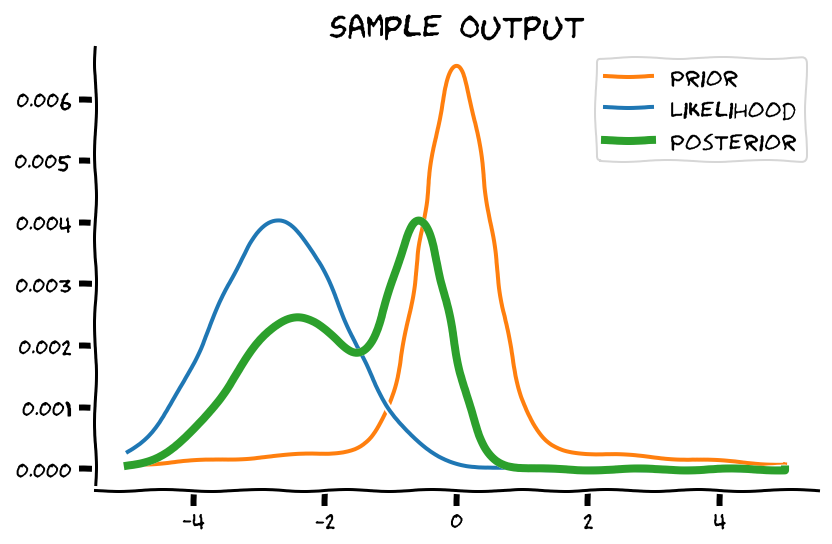

In [5]:
x, prior, likelihood, posterior = generate_example_pdfs()
plot_posterior_components(x, prior, likelihood, posterior)

# Section 1: The Cost Functions

Next, we will implement the cost functions. 
A cost function determines the "cost" (or penalty) of estimating $\hat{x}$ when the true or correct quantity is really $x$ (this is essentially the cost of the error between the true stimulus value: $x$ and our estimate: $\hat x$ -- Note that the error can be defined in different ways):

$$\begin{eqnarray}
\textrm{Mean Squared Error} &=& (x - \hat{x})^2 \\ 
\textrm{Absolute Error} &=& \big|x - \hat{x}\big| \\ 
\textrm{Zero-One Loss} &=& \begin{cases}
                            0,& \text{if } x = \hat{x} \\
                            1,              & \text{otherwise}
                            \end{cases}
\end{eqnarray}
$$

In the cell below, fill in the body of these cost function. Each function should take one single value for $x$ (the true stimulus value : $x$) and one or more possible value estimates: $\hat{x}$. 

Return an array containing the costs associated with predicting $\hat{x}$ when the true value is $x$. Once you have written all three functions, uncomment the final line to visulize your results.

 _Hint:_ These functions are easy to write (1 line each!) but be sure *all* three functions return arrays of `np.float` rather than another data type.

## Exercise 1: Implement the cost functions

In [6]:
def mse(x, x_hats):
  """Mean-squared error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      same shape/type as x_hats): MSE costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the MSE cost function
  #
  ### Comment out the line below to test your function
  raise NotImplementedError("You need to complete the MSE cost function!")
  ##############################################################################

  my_mse = ...
  return my_mse


def abs_err(x, x_hats):
  """Absolute error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats): absolute error costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the absolute error cost function
  #
  ### Comment out the line below to test your function
  raise NotImplementedError("You need to complete the absolute error function!")
  ##############################################################################

  my_abs_err = ...
  return my_abs_err


def zero_one_loss(x, x_hats):
  """Zero-One loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats) of the 0-1 Loss costs associated with predicting x_hat instead of x
  """

  ##############################################################################
  # Complete the zero-one loss cost function
  #
  ### Comment out the line below to test your function
  raise NotImplementedError("You need to complete the 0-1 loss cost function!")
  ##############################################################################

  my_zero_one_loss = ...
  return my_zero_one_loss


## When you are done with the functions above, uncomment the line below to
## visualize them
# visualize_loss_functions(mse, abs_err, zero_one_loss)

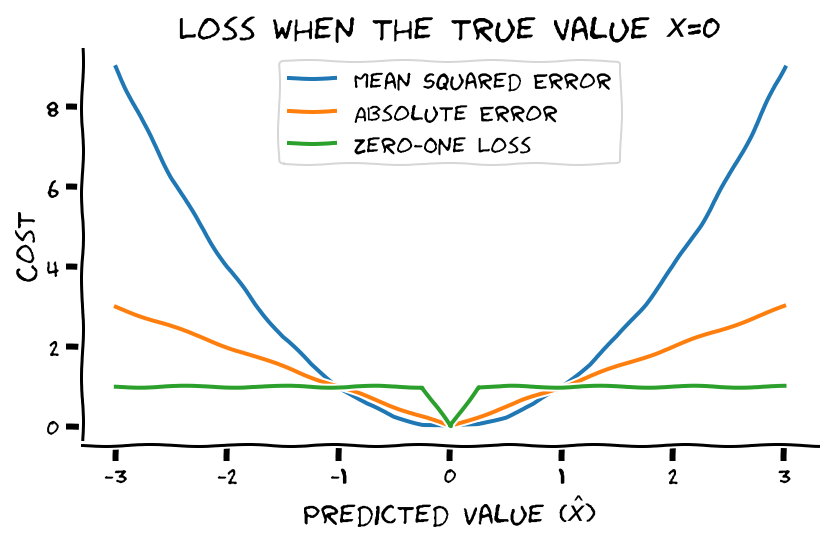

In [7]:
# to_remove solution

def mse(x, x_hats):
  """Mean-squared error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      same shape/type as x_hats): MSE costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the MSE cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the MSE cost function!")
  ##############################################################################

  my_mse = (x - x_hats)**2
  return my_mse


def abs_err(x, x_hats):
  """Absolute error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats): absolute error costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the absolute error cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the absolute error function!")
  ##############################################################################

  my_abs_err = np.abs(x - x_hats)
  return my_abs_err


def zero_one_loss(x, x_hats):
  """Zero-One loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats) of the 0-1 Loss costs associated with predicting x_hat instead of x
  """

  ##############################################################################
  # Complete the zero-one loss cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the 0-1 loss cost function!")
  ##############################################################################

  my_zero_one_loss = (x != x_hats).astype(np.float)
  return my_zero_one_loss


## When you are done with the functions above, uncomment the line below to
## visualize them
with plt.xkcd():
  visualize_loss_functions(mse, abs_err, zero_one_loss)

# Section 2: Expected Loss
    


Video available at https://youtube.com/watch?v=FTBpCfylV_Y


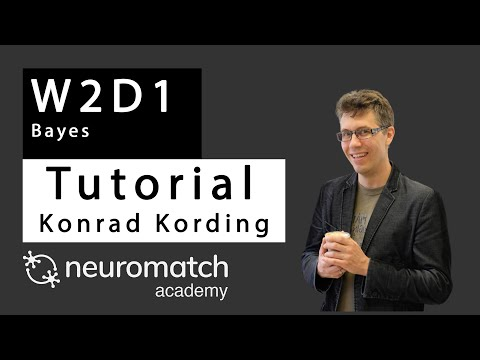

In [8]:
#@title Video 2: Expected Loss
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='FTBpCfylV_Y', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

A posterior distribution tells us about the confidence or credibility we assign to different choices. A cost function describes the penalty we incur when choosing an incorrect option. These concepts can be combined into an *expected loss* function. Expected loss is defined as:

$$
\begin{eqnarray}
    \mathbb{E}[\text{Loss} | \hat{x}] = \int L[\hat{x},x] \odot  p(x|\tilde{x}) dx
\end{eqnarray}
$$

where $L[ \hat{x}, x]$ is the loss function, $p(x|\tilde{x})$ is the posterior, and $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e., elementwise multiplication), and $\mathbb{E}[\text{Loss} | \hat{x}]$ is the expected loss. 

In this exercise, we will calculate the expected loss for the: means-squared error, the absolute error, and the zero-one loss over our bimodal posterior $p(x | \tilde x)$. 

**Suggestions:**
* We already pre-completed the code (commented-out) to calculate the mean-squared error, absolute error, and zero-one loss between $x$ and an estimate $\hat x$ using the functions you created in exercise 1
* Calculate the expected loss ($\mathbb{E}[MSE Loss]$) using your posterior (imported above as `posterior`) & each of the loss functions described above (MSELoss, ABSELoss, and Zero-oneLoss).
* Find the x position that minimizes the expected loss for each cost function and plot them using the `loss_plot` function provided (commented-out)

## Exercise 2: Finding the expected loss empirically via integration


In [9]:
def expected_loss_calculation(x, posterior):

  ExpectedLoss_MSE = np.zeros_like(x)
  ExpectedLoss_ABSE = np.zeros_like(x)
  ExpectedLoss_01 = np.zeros_like(x)

  for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    ###################################################################
    ## Insert code below to find the expected loss under each loss function
    ##
    ## remove the raise when the function is complete
    raise NotImplementedError("Calculate the expected loss over all x values!")
    ###################################################################

    MSELoss = mse(estimate, x)
    ExpectedLoss_MSE[idx] = ...

    ABSELoss = abs_err(estimate, x)
    ExpectedLoss_ABSE[idx] = ...

    ZeroOneLoss = zero_one_loss(estimate, x)
    ExpectedLoss_01[idx] = ...

  ###################################################################
  ## Now, find the `x` location that minimizes expected loss
  ##
  ## remove the raise when the function is complete
  raise NotImplementedError("Finish the Expected Loss calculation")
  ###################################################################

  min_MSE = ...
  min_ABSE = ...
  min_01 = ...

  return (ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,
          min_MSE, min_ABSE, min_01)

## Uncomment the lines below to plot the expected loss as a function of the estimates
#ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,  min_MSE, min_ABSE, min_01 = expected_loss_calculation(x, posterior)
#loss_plot(x, ExpectedLoss_MSE, min_MSE, f"Mean Squared Error = {min_MSE:.2f}")
#loss_plot(x, ExpectedLoss_ABSE, min_ABSE, f"Absolute Error = {min_ABSE:.2f}")
#loss_plot(x, ExpectedLoss_01, min_01, f"Zero-One Error = {min_01:.2f}")

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


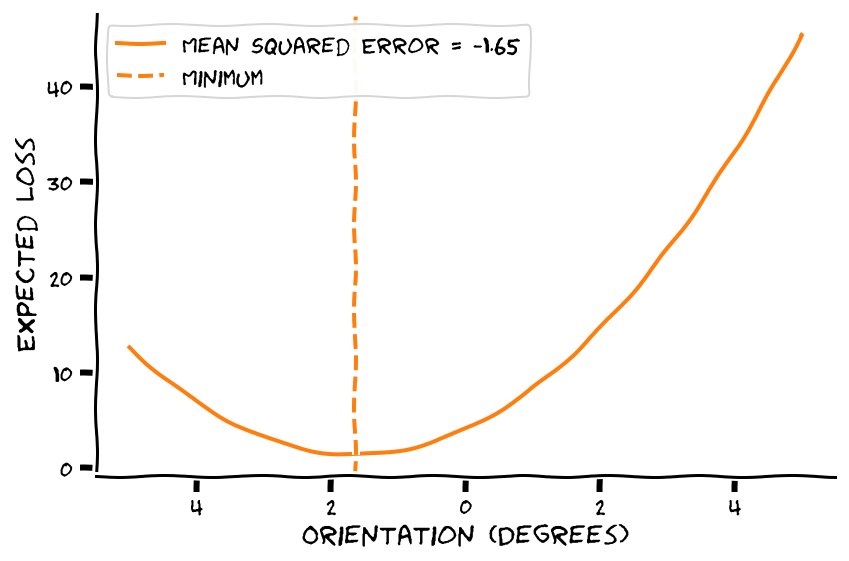

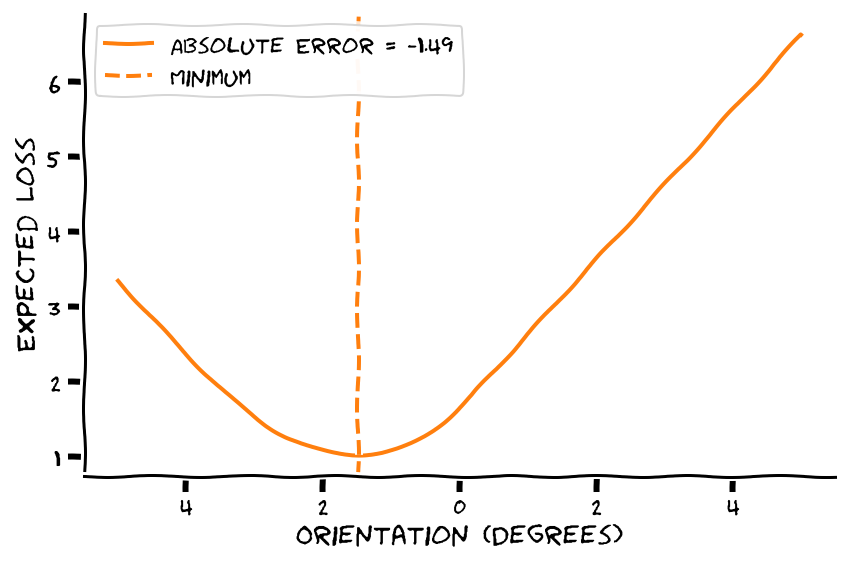

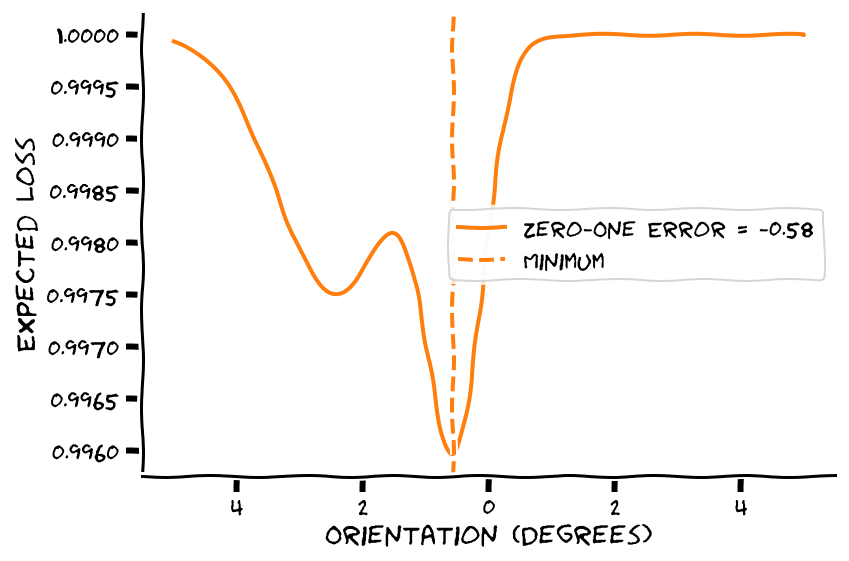

In [10]:
# to_remove solution
def expected_loss_calculation(x, posterior):

  ExpectedLoss_MSE = np.zeros_like(x)
  ExpectedLoss_ABSE = np.zeros_like(x)
  ExpectedLoss_01 = np.zeros_like(x)

  for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    ###################################################################
    ## Insert code below to find the expected loss under each loss function
    ##
    ## remove the raise when the function is complete
    #raise NotImplementedError("Calculate the expected loss over all x values!")
    ###################################################################

    MSELoss = mse(estimate, x)
    ExpectedLoss_MSE[idx] = np.sum(MSELoss * posterior)

    ABSELoss = abs_err(estimate, x)
    ExpectedLoss_ABSE[idx] = np.sum(ABSELoss * posterior)

    ZeroOneLoss = zero_one_loss(estimate, x)
    ExpectedLoss_01[idx] = np.sum(ZeroOneLoss * posterior)

  ###################################################################
  ## Now, find the `x` location that minimizes expected loss
  ##
  ## remove the raise when the function is complete
  # raise NotImplementedError("Finish the Expected Loss calculation")
  ###################################################################

  min_MSE = x[np.argmin(ExpectedLoss_MSE)]
  min_ABSE = x[np.argmin(ExpectedLoss_ABSE)]
  min_01 = x[np.argmin(ExpectedLoss_01)]

  return (ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,
          min_MSE, min_ABSE, min_01)

## Uncomment the lines below to plot the expected loss as a function of the estimates
ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,  min_MSE, min_ABSE, min_01 = expected_loss_calculation(x, posterior)

with plt.xkcd():
  loss_plot(x, ExpectedLoss_MSE, min_MSE, f"Mean Squared Error = {min_MSE:.2f}")
  loss_plot(x, ExpectedLoss_ABSE, min_ABSE, f"Absolute Error = {min_ABSE:.2f}")
  loss_plot(x, ExpectedLoss_01, min_01, f"Zero-One Error = {min_01:.2f}")

# Section 3: Analytical Solutions
    

Video available at https://youtube.com/watch?v=wmDD51N9rs0


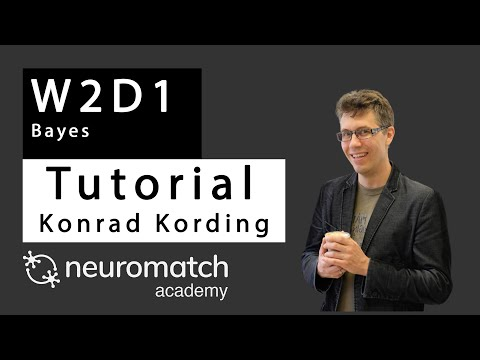

In [11]:
#@title Video 3: Analytical Solutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='wmDD51N9rs0', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In the previous exercise, we found the minimum expected loss via brute-force: we searched over all possible values of $x$ and found the one that minimized each of our loss functions. This is feasible for our small toy example, but can quickly become intractable. 

Fortunately, the three loss functions examined in this tutorial have are minimized at specific points on the posterior, corresponding to the itss mean, median, and mode. To verify this property, we have replotted the loss functions from Exercise 2 below, with the posterior on the same scale beneath. The mean, median, and mode are marked on the posterior. 

Which loss form corresponds to each summary statistics? 
 

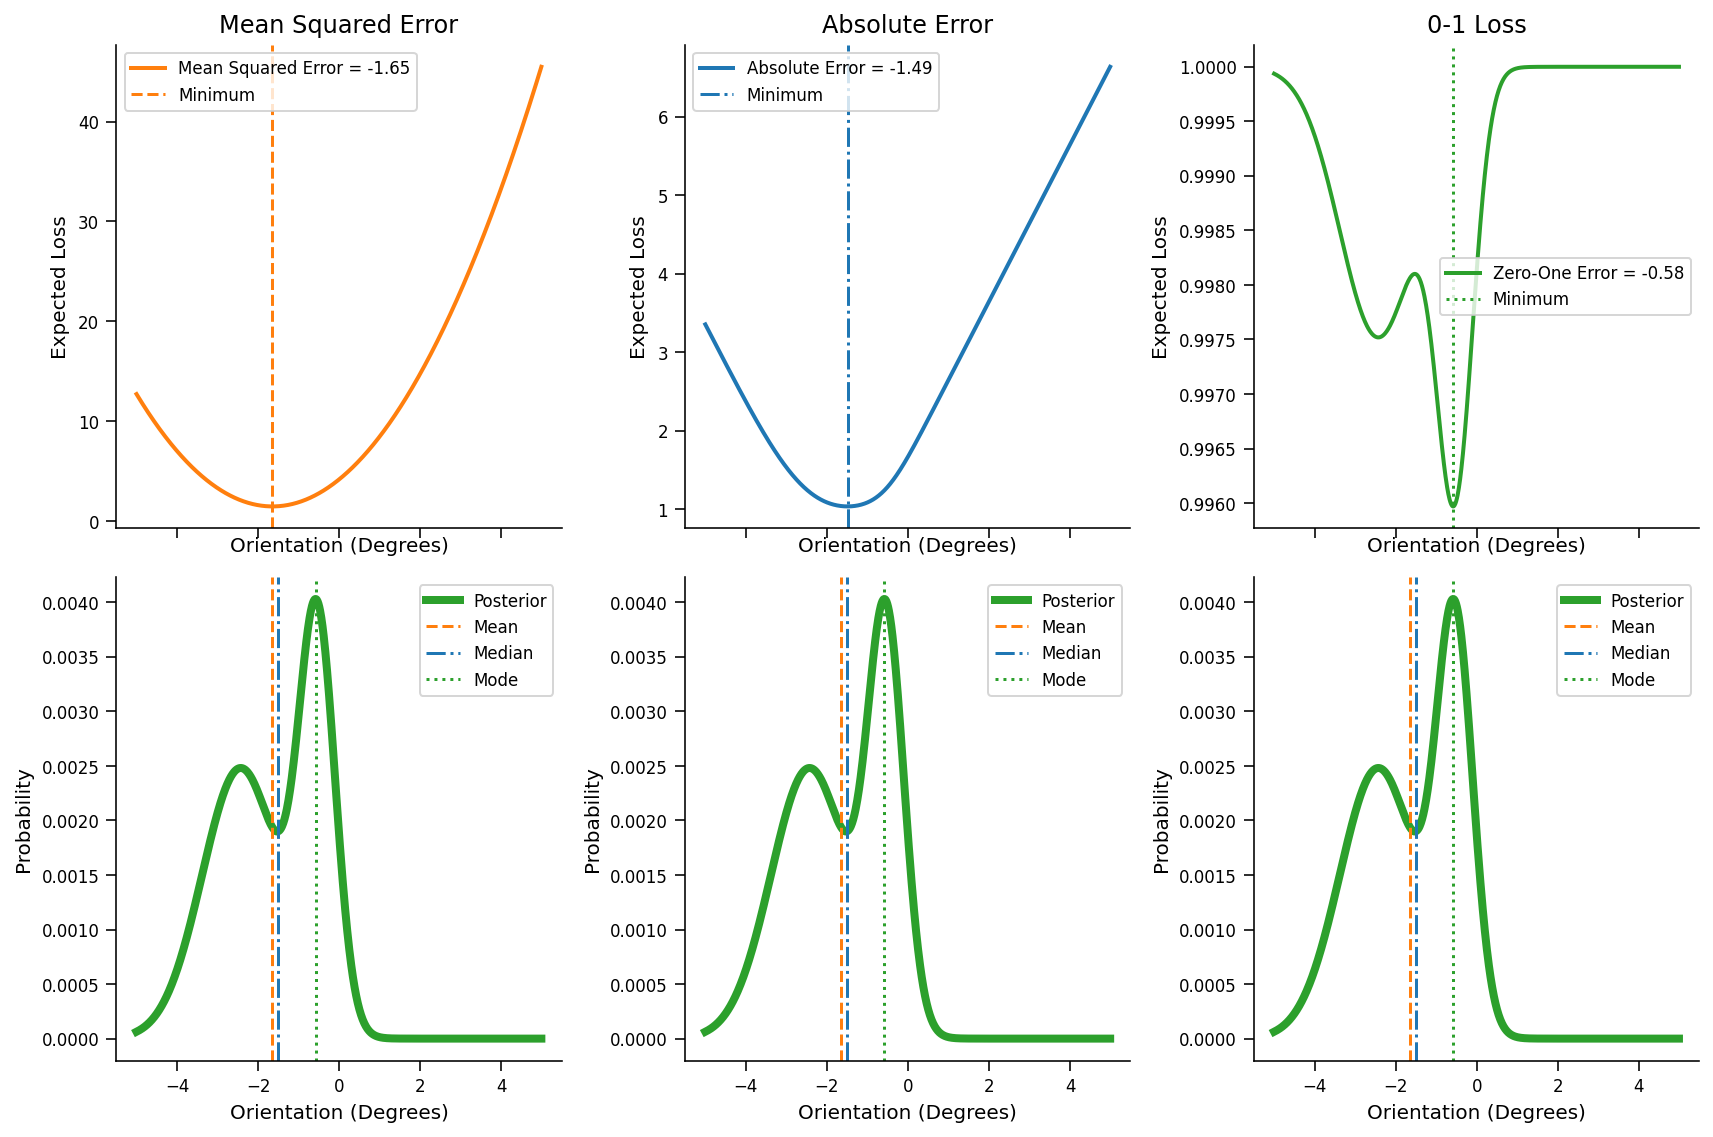

In [12]:
loss_plot_subfigures(x,
                    ExpectedLoss_MSE, min_MSE, f"Mean Squared Error = {min_MSE:.2f}",
                    ExpectedLoss_ABSE, min_ABSE, f"Absolute Error = {min_ABSE:.2f}",
                    ExpectedLoss_01, min_01, f"Zero-One Error = {min_01:.2f}")

In [13]:
#to_remove explanation
"""
As you might recall from W1D3, the mean minimizes the mean-squared error.
Absolute error is minimized by the median, while zero-one loss is minimized
at the posterior's mode.
"""

"\nAs you might recall from W1D3, the mean minimizes the mean-squared error.\nAbsolute error is minimized by the median, while zero-one loss is minimized\nat the posterior's mode.\n"

# Section 4: Conclusion


Video available at https://youtube.com/watch?v=3nTvamDVx2s


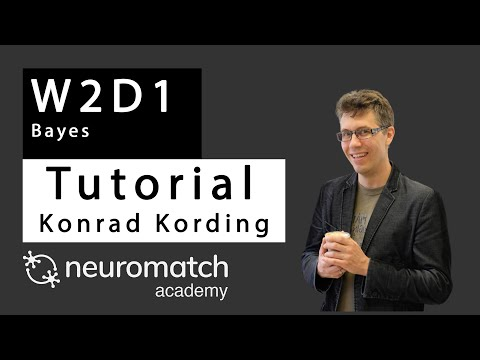

In [14]:
#@title Video 4: Outro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='3nTvamDVx2s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In this tutorial, we learned about three kinds of cost functions: mean-squared error, absolute error, and zero-one loss. We used expected loss to quantify the results of making a decision, and showed that optimizing under different cost functions led us to choose different locations on the posterior. Finally, we found that these optimal locations can be identified analytically, sparing us from a brute-force search. 

Here are some additional questions to ponder:
*   Suppose your professor offered to grade your work with a zero-one loss or mean square error. 
    * When might you choose each?
    * Which would be easier to learn from?
* All of the loss functions we considered are symmetrical. Are there situations where an asymmetrical loss function might make sense? How about a negative one?







